In [1]:
# %pip install -r /home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/model/CelebV2/requirements.txt

# # Step 1: Uninstall incompatible NumPy version
# %pip uninstall numpy -y
# # Step 2: Install compatible NumPy version (< 2.0.0)
# %pip install "numpy>=1.21.0,<2.0.0"
# # Step 3: Verify NumPy version
# import numpy as np
# print(f"✅ NumPy version: {np.__version__}")
# print(f"Expected: < 2.0.0 (you should see 1.x.x)")

In [2]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

2025-10-18 11:14:28.376870: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 11:14:28.417269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-18 11:14:28.759761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-18 11:14:28.759839: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-18 11:14:28.761447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
# Define the path to the dataset
base_path = '/home/huuquangdang/huu.quang.dang/thesis/Dataset/celeb_df_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,264_id37_0009_frame_0001.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,264,1,fake,0
1,271_id38_0006_frame_0014.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,271,14,fake,0
2,015_id10_0006_frame_0027.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,15,27,fake,0
3,392_id4_0007_frame_0028.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,392,28,fake,0
4,029_id11_0010_frame_0004.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,29,4,fake,0
...,...,...,...,...,...,...
32367,475_id58_0004_frame_0012.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,475,12,real,1
32368,014_id10_0005_frame_0012.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,14,12,real,1
32369,365_id48_0000_frame_0023.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,365,23,real,1
32370,091_id20_0000_frame_0026.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,91,26,real,1


In [5]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [6]:
# !pip install opencv-python

In [7]:
# Load pre-extracted CSV features for feature fusion
print("📂 Loading pre-extracted OpenFace features from CSV files...")
csv_fake_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/fake/op_vectors_fake_v1.csv'
csv_real_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/real/op_vectors_real_v1.csv'

df_fake_features = pd.read_csv(csv_fake_path, header=None)
df_real_features = pd.read_csv(csv_real_path, header=None)

# Combine both dataframes
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)
df_all_features.columns = ['filename'] + [f'feat_{i}' for i in range(df_all_features.shape[1] - 1)]

# Create a dictionary for fast lookup: filename -> features
openface_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    features = row.iloc[1:].values.astype('float32')
    openface_features[filename] = features

csv_feature_dim = len(features)
print(f"✅ Loaded {len(openface_features)} feature vectors")
print(f"✅ Each vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")

📂 Loading pre-extracted OpenFace features from CSV files...
✅ Loaded 16223 feature vectors
✅ Each vector has 674 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


# 🔬 Model: TCN (Temporal Conv Net) + Residual Blocks + KAN

This cell implements **TCN (dilated 1D CNN) with Residual Blocks** for sequence modeling, while maintaining:

- ✅ Same function names (`VideoSequence`, `build_model`, `hmm_postprocess`)

- ✅ Same 1-to-1 feature fusion (MobileNet + CSV)

- ✅ Same normalization strategy

- ✅ Enhanced with TCN and Residual Blocks

In [8]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, Dropout, Dense, GlobalAveragePooling2D, 
    Concatenate, BatchNormalization, Conv1D, Add, Activation, LayerNormalization, GlobalAveragePooling1D
    )
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration (same as before)
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Normalize CSV features (same normalization strategy)
print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in openface_features:
            all_csv_features.append(openface_features[filename])

csv_scaler = StandardScaler()
csv_scaler.fit(all_csv_features)
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")

# Data generator (SAME NAME, same functionality)
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load CSV features and normalize (1-to-1 mapping)
                filename = os.path.basename(path)
                if filename in openface_features:
                    csv_feat = openface_features[filename]
                    csv_feat = csv_scaler.transform([csv_feat])[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)

# TCN Residual Block
def tcn_residual_block(x, filters, kernel_size, dilation_rate, block_num):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_1')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_1')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_1')(x)
    x = Dropout(0.2, name=f'tcn_dropout_{block_num}_1')(x)
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, name=f'tcn_conv_{block_num}_2')(x)
    x = LayerNormalization(name=f'tcn_ln_{block_num}_2')(x)
    x = Activation('relu', name=f'tcn_relu_{block_num}_2')(x)
    x = Dropout(0.2, name=f'tcn_dropout_{block_num}_2')(x)
    # Residual connection
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same', name=f'tcn_shortcut_{block_num}')(shortcut)
    x = Add(name=f'tcn_add_{block_num}')([x, shortcut])
    x = Activation('relu', name=f'tcn_out_relu_{block_num}')(x)
    return x

# TCN + Residual Blocks Model (NO KAN)
def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # BatchNormalization before fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)
    
    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])
    
    # TCN blocks (dilated 1D CNN with residuals)
    x = x_combined
    for i, (filters, kernel_size, dilation_rate) in enumerate([(128, 3, 1), (128, 3, 2), (128, 3, 4), (128, 3, 8)]):
        x = tcn_residual_block(x, filters, kernel_size, dilation_rate, i+1)
    
    # Global average pooling over time dimension to get fixed-size output
    x = GlobalAveragePooling1D(name='global_avg_pool')(x)
    x = Dropout(0.2, name='dropout_tcn')(x)
    
    # Classification layers (NO KAN)
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(0.2, name='dropout_3')(x)
    x = Dense(32, activation='relu', name='dense_2')(x)
    x = Dropout(0.2, name='dropout_4')(x)
    
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='TCN_Residual')
    return model

# HMM post-processing (SAME NAME, unchanged)
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold
print("\n🚀 Starting TCN + Residual Blocks Training (NO KAN):")
print("   ✅ TCN (dilated 1D CNN, residual blocks)")
print("   ✅ Normalized CSV features (1-to-1 mapping)")
print("   ✅ MobileNet (last 20 layers trainable)")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - TCN_Residual")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size, csv_feature_dim)
    model.compile(optimizer=Adamax(3e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    print(f"\n📈 Model Architecture:")
    print(f"   - Model: TCN + Residual Blocks (NO KAN)")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - TCN: 4 blocks, dilations 1/2/4/8")
    print(f"   - Learning rate: 3e-4")

    model_path = f"best_model_fold{fold}_tcn_res.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results (TCN_Residual):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - TCN_Residual Model (NO KAN)")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))

🔧 Computing CSV feature statistics for normalization...
✅ CSV feature normalization fitted on 10840 samples

🚀 Starting TCN + Residual Blocks Training (NO KAN):
   ✅ TCN (dilated 1D CNN, residual blocks)
   ✅ Normalized CSV features (1-to-1 mapping)
   ✅ MobileNet (last 20 layers trainable)
   ✅ HMM post-processing


📊 Fold 1/5 - TCN_Residual

📈 Model Architecture:
   - Model: TCN + Residual Blocks (NO KAN)
   - Total params: 3,623,881
   - Trainable params: 2,568,069
   - TCN: 4 blocks, dilations 1/2/4/8
   - Learning rate: 3e-4
Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7523 - accuracy: 0.5615
Epoch 1: val_accuracy improved from -inf to 0.51724, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 98s 4s/step - loss: 0.7523 - accuracy: 0.5615 - val_loss: 0.6957 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.6359
Epoch 2: val_accuracy did not improve from 0.51724
25/25 [==============================] - 88s 3s/step - loss: 0.6471 - accuracy: 0.6359 - val_loss: 0.8472 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.7500
Epoch 3: val_accuracy did not improve from 0.51724
25/25 [==============================] - 87s 3s/step - loss: 0.5082 - accuracy: 0.7500 - val_loss: 0.9350 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8128
Epoch 4: val_accuracy did not improve from 0.51724

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 87s 3s/step - loss: 0.4299 - accuracy: 0.8128 - val_loss: 0.9702 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s -

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.8897
Epoch 7: val_accuracy improved from 0.52874 to 0.56322, saving model to best_model_fold1_tcn_res.h5

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 82s 3s/step - loss: 0.2769 - accuracy: 0.8897 - val_loss: 0.9612 - val_accuracy: 0.5632 - lr: 1.5000e-04
Epoch 8/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9000
Epoch 8: val_accuracy improved from 0.56322 to 0.58621, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 80s 3s/step - loss: 0.2594 - accuracy: 0.9000 - val_loss: 0.9686 - val_accuracy: 0.5862 - lr: 7.5000e-05
Epoch 9/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.9295
Epoch 9: val_accuracy improved from 0.58621 to 0.60920, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 79s 3s/step - loss: 0.2228 - accuracy: 0.9295 - val_loss: 0.9013 - val_accuracy: 0.6092 - lr: 7.5000e-05
Epoch 10/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9256
Epoch 10: val_accuracy improved from 0.60920 to 0.63218, saving model to best_model_fold1_tcn_res.h5

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.2078 - accuracy: 0.9256 - val_loss: 0.8865 - val_accuracy: 0.6322 - lr: 7.5000e-05
Epoch 11/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9295
Epoch 11: val_accuracy improved from 0.63218 to 0.66667, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2056 - accuracy: 0.9295 - val_loss: 0.8500 - val_accuracy: 0.6667 - lr: 3.7500e-05
Epoch 12/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9218
Epoch 12: val_accuracy improved from 0.66667 to 0.68966, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2044 - accuracy: 0.9218 - val_loss: 0.8091 - val_accuracy: 0.6897 - lr: 3.7500e-05
Epoch 13/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9282
Epoch 13: val_accuracy improved from 0.68966 to 0.70115, saving model to best_model_fold1_tcn_res.h5

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1998 - accuracy: 0.9282 - val_loss: 0.8008 - val_accuracy: 0.7011 - lr: 3.7500e-05
Epoch 14/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9231
Epoch 14: val_accuracy improved from 0.70115 to 0.72414, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2085 - accuracy: 0.9231 - val_loss: 0.7694 - val_accuracy: 0.7241 - lr: 1.8750e-05
Epoch 15/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9269
Epoch 15: val_accuracy did not improve from 0.72414
25/25 [==============================] - 78s 3s/step - loss: 0.1961 - accuracy: 0.9269 - val_loss: 0.7812 - val_accuracy: 0.7241 - lr: 1.8750e-05
Epoch 16/50
25/25 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9218
Epoch 16: val_accuracy did not improve from 0.72414

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.2010 - accuracy: 0.9218 - val_loss: 0.7562 - val_accuracy: 0.7241 - lr: 1.8750e-05
Epoch 17/50
25/25 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9179
Epoch 17: val_accuracy improved from 0.72414 to 0.74713, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 79s 3s/step - loss: 0.2045 - accuracy: 0.9179 - val_loss: 0.7331 - val_accuracy: 0.7471 - lr: 9.3750e-06
Epoch 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.9231
Epoch 18: val_accuracy did not improve from 0.74713
25/25 [==============================] - 78s 3s/step - loss: 0.1903 - accuracy: 0.9231 - val_loss: 0.7164 - val_accuracy: 0.7471 - lr: 9.3750e-06
Epoch 19/50
25/25 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9385
Epoch 19: val_accuracy did not improve from 0.74713

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.1870 - accuracy: 0.9385 - val_loss: 0.6976 - val_accuracy: 0.7471 - lr: 9.3750e-06
Epoch 20/50
25/25 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.9308
Epoch 20: val_accuracy improved from 0.74713 to 0.75862, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1981 - accuracy: 0.9308 - val_loss: 0.6861 - val_accuracy: 0.7586 - lr: 4.6875e-06
Epoch 

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9385
Epoch 21: val_accuracy did not improve from 0.75862
25/25 [==============================] - 77s 3s/step - loss: 0.1794 - accuracy: 0.9385 - val_loss: 0.6747 - val_accuracy: 0.7586 - lr: 4.6875e-06
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9333
Epoch 22: val_accuracy improved from 0.75862 to 0.77011, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 79s 3s/step - loss: 0.1855 - accuracy: 0.9333 - val_loss: 0.6672 - val_accuracy: 0.7701 - lr: 4.6875e-06
Epoch 23/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9385
Epoch 23: val_accuracy improved from 0.77011 to 0.78161, saving model to best_model_fold1_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1844 - accuracy: 0.9385 - val_loss: 0.6616 - val_accuracy: 0.7816 - lr: 4.6875e-06
Epoch 24/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9474
Epoch 24: val_accuracy did not improve from 0.78161
25/25 [==============================] - 78s 3s/step - loss: 0.1825 - accuracy: 0.9474 - val_loss: 0.6569 - val_accuracy: 0.7816 - lr: 4.6875e-06
Epoch 25/50
25/25 [==============================] - ETA: 0s - loss: 0.1654 - accuracy: 0.9462
Epoch 25: val_accuracy did not improve from 0.78161
25/25 [==============================] - 78s 3s/step - loss: 0.1654 - accuracy: 0.9462 - val_loss: 0.6482 - val_accuracy: 0.7816 - lr: 4.6875e-06
Epoch 26/50
25/25 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9333
Epoch 26: val_accuracy did not improve from 0.78161
25/25 [==============================] - 78s 3s/step - loss: 0.1791 - accuracy: 0.9333 - val_loss: 0.6451 - val_accuracy: 0.7816 - lr: 4.6875e-06
Epoch 27/50
25/25 [==============================] - ETA: 0s - loss: 0.1715 - accuracy: 0.9487
Epoch 27: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



📈 Model Architecture:
   - Model: TCN + Residual Blocks (NO KAN)
   - Total params: 3,623,881
   - Trainable params: 2,568,069
   - TCN: 4 blocks, dilations 1/2/4/8
   - Learning rate: 3e-4
Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.8573 - accuracy: 0.5192
Epoch 1: val_accuracy improved from -inf to 0.56322, saving model to best_model_fold2_tcn_res.h5
25/25 [==============================] - 81s 3s/step - loss: 0.8573 - accuracy: 0.5192 - val_loss: 0.6851 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6684 - accuracy: 0.6538
Epoch 2: val_accuracy did not improve from 0.56322
25/25 [==============================] - 78s 3s/step - loss: 0.6684 - accuracy: 0.6538 - val_loss: 0.7567 - val_accuracy: 0.4828 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.6885
Epoch 3: val_accuracy did not improve from 0.56322
25/25 [==============================] - 78s 3s/step - loss: 0.5997 - accuracy: 0.6885 - val_loss: 0.7889 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.7462
Epoch 4: val_accuracy did not improve from 0.56322

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 78s 3s/step - loss: 0.5328 - accuracy: 0.7462 - val_loss: 0.8245 - val_accuracy: 0.5287 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s -

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.6936
Epoch 2: val_accuracy did not improve from 0.50575
25/25 [==============================] - 78s 3s/step - loss: 0.6095 - accuracy: 0.6936 - val_loss: 1.0456 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.7795
Epoch 3: val_accuracy did not improve from 0.50575
25/25 [==============================] - 78s 3s/step - loss: 0.4780 - accuracy: 0.7795 - val_loss: 1.1207 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8077
Epoch 4: val_accuracy improved from 0.50575 to 0.51724, saving model to best_model_fold3_tcn_res.h5

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 78s 3s/step - loss: 0.4015 - accuracy: 0.8077 - val_loss: 1.3382 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.8551
Epoch 5: val_accuracy improved from 0.51724 to 0.52874, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.3022 - accuracy: 0.8551 - val_loss: 1.3165 - val_accuracy: 0.5287 - lr: 1.5000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.8821
Epoch 6: val_accuracy did not improve from 0.52874
25/25 [==============================] - 78s 3s/step - loss: 0.2752 - accuracy: 0.8821 - val_loss: 1.4686 - val_accuracy: 0.5287 - lr: 1.5000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.8936
Epoch 7: val_accuracy did not improve from 0.52874

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.2350 - accuracy: 0.8936 - val_loss: 1.4968 - val_accuracy: 0.5287 - lr: 1.5000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9154
Epoch 8: val_accuracy did not improve from 0.52874
25/25 [==============================] - 78s 3s/step - loss: 0.2245 - accuracy: 0.9154 - val_loss: 1.5290 - val_accuracy: 0.5287 - lr: 7.5000e-05
Epoch 9/50
25/25 [==============================] - ETA: 0s -

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9179
Epoch 10: val_accuracy improved from 0.57471 to 0.59770, saving model to best_model_fold3_tcn_res.h5

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1922 - accuracy: 0.9179 - val_loss: 1.3177 - val_accuracy: 0.5977 - lr: 7.5000e-05
Epoch 11/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9295
Epoch 11: val_accuracy did not improve from 0.59770
25/25 [==============================] - 79s 3s/step - loss: 0.1738 - accuracy: 0.9295 - val_loss: 1.3915 - val_accuracy: 0.5977 - lr: 3.7500e-05
Epoch 12/50
25/25 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9372
Epoch 12: val_accuracy improved from 0.59770 to 0.60920, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1682 - accuracy: 0.9372 - val_loss: 1.3770 - val_accuracy: 0.6092 - lr: 3.7500e-05
Epoch 13/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9410
Epoch 13: val_accuracy did not improve from 0.60920

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
25/25 [==============================] - 79s 3s/step - loss: 0.1623 - accuracy: 0.9410 - val_loss: 1.3709 - val_accuracy: 0.6092 - lr: 3.7500e-05
Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9577
Epoch 14: val_accuracy improved from 0.60920 to 0.62069, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1296 - accuracy: 0.9577 - val_loss: 1.2988 - val_accuracy: 0.6207 - lr: 1.8750e-05
Epoch 15/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1537 - accuracy: 0.9436
Epoch 15: val_accuracy improved from 0.62069 to 0.64368, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1537 - accuracy: 0.9436 - val_loss: 1.2844 - val_accuracy: 0.6437 - lr: 1.8750e-05
Epoch 16/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9538
Epoch 16: val_accuracy improved from 0.64368 to 0.65517, saving model to best_model_fold3_tcn_res.h5

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.1331 - accuracy: 0.9538 - val_loss: 1.2429 - val_accuracy: 0.6552 - lr: 1.8750e-05
Epoch 17/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9513
Epoch 17: val_accuracy improved from 0.65517 to 0.66667, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1457 - accuracy: 0.9513 - val_loss: 1.1825 - val_accuracy: 0.6667 - lr: 9.3750e-06
Epoch 18/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9590
Epoch 18: val_accuracy improved from 0.66667 to 0.70115, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1292 - accuracy: 0.9590 - val_loss: 1.1134 - val_accuracy: 0.7011 - lr: 9.3750e-06


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 19/50
25/25 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9603
Epoch 19: val_accuracy improved from 0.70115 to 0.72414, saving model to best_model_fold3_tcn_res.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 82s 3s/step - loss: 0.1213 - accuracy: 0.9603 - val_loss: 1.0460 - val_accuracy: 0.7241 - lr: 9.3750e-06
Epoch 20/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9513
Epoch 20: val_accuracy improved from 0.72414 to 0.73563, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 80s 3s/step - loss: 0.1359 - accuracy: 0.9513 - val_loss: 0.9918 - val_accuracy: 0.7356 - lr: 4.6875e-06
Epoch 21/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9410
Epoch 21: val_accuracy improved from 0.73563 to 0.74713, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 80s 3s/step - loss: 0.1385 - accuracy: 0.9410 - val_loss: 0.9412 - val_accuracy: 0.7471 - lr: 4.6875e-06
Epoch 22/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9474
Epoch 22: val_accuracy did not improve from 0.74713

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.
25/25 [==============================] - 79s 3s/step - loss: 0.1396 - accuracy: 0.9474 - val_loss: 0.8954 - val_accuracy: 0.7356 - lr: 4.6875e-06
Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.9436
Epoch 23: val_accuracy did not improve from 0.74713
25/25 [==============================] - 81s 3s/step - loss: 0.1415 - accuracy: 0.9436 - val_loss: 0.8442 - val_accuracy: 0.7356 - lr: 2.3438e-06
Epoch 24/50
25/25 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9500
Epoch 24: val_accuracy did not improve from 0.74713
25/25 [==============================] - 79s 3s/step - loss: 0.1336 - accuracy: 0.9500 - val_loss: 0.8025 - val_accuracy: 0.7471 - lr: 2.3438e-06
Epoch 25/50
25/25 [==============================] - E

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9577
Epoch 26: val_accuracy improved from 0.78161 to 0.80460, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 80s 3s/step - loss: 0.1246 - accuracy: 0.9577 - val_loss: 0.7176 - val_accuracy: 0.8046 - lr: 2.3438e-06
Epoch 27/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9474
Epoch 27: val_accuracy did not improve from 0.80460
25/25 [==============================] - 78s 3s/step - loss: 0.1301 - accuracy: 0.9474 - val_loss: 0.6782 - val_accuracy: 0.8046 - lr: 2.3438e-06
Epoch 28/50
25/25 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.9603
Epoch 28: val_accuracy improved from 0.80460 to 0.81609, saving model to best_model_fold3_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1314 - accuracy: 0.9603 - val_loss: 0.6446 - val_accuracy: 0.8161 - lr: 2.3438e-06
Epoch 29/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9538
Epoch 29: val_accuracy did not improve from 0.81609
25/25 [==============================] - 78s 3s/step - loss: 0.1251 - accuracy: 0.9538 - val_loss: 0.6121 - val_accuracy: 0.8161 - lr: 2.3438e-06
Epoch 30/50
25/25 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9603
Epoch 30: val_accuracy did not improve from 0.81609
25/25 [==============================] - 78s 3s/step - loss: 0.1308 - accuracy: 0.9603 - val_loss: 0.5872 - val_accuracy: 0.8161 - lr: 2.3438e-06
Epoch 31/50
25/25 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9538
Epoch 31: val_accuracy did not improve from 0.81609
25/25 [==============================] - 78s 3s/step - loss: 0.1294 - accuracy: 0.9538 - val_loss: 0.5585 - val_accuracy: 0.8161 - lr: 2.3438e-06
Epoch 32/50
25/25 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9513
Epoch 32: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.6590
Epoch 2: val_accuracy improved from 0.49425 to 0.51724, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.6304 - accuracy: 0.6590 - val_loss: 0.8545 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.7564
Epoch 3: val_accuracy improved from 0.51724 to 0.56322, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.4894 - accuracy: 0.7564 - val_loss: 0.8548 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.4091 - accuracy: 0.8154
Epoch 4: val_accuracy did not improve from 0.56322
25/25 [==============================] - 78s 3s/step - loss: 0.4091 - accuracy: 0.8154 - val_loss: 0.8588 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.8590
Epoch 5: val_accuracy improved from 0.56322 to 0.64368, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.3110 - accuracy: 0.8590 - val_loss: 0.6641 - val_accuracy: 0.6437 - lr: 3.0000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9013
Epoch 6: val_accuracy improved from 0.64368 to 0.68966, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 82s 3s/step - loss: 0.2497 - accuracy: 0.9013 - val_loss: 0.6791 - val_accuracy: 0.6897 - lr: 3.0000e-04
Epoch 7/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9077
Epoch 7: val_accuracy improved from 0.68966 to 0.71264, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 80s 3s/step - loss: 0.2331 - accuracy: 0.9077 - val_loss: 0.6698 - val_accuracy: 0.7126 - lr: 3.0000e-04
Epoch 8/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9141
Epoch 8: val_accuracy improved from 0.71264 to 0.72414, saving model to best_model_fold4_tcn_res.h5

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 80s 3s/step - loss: 0.2095 - accuracy: 0.9141 - val_loss: 0.8326 - val_accuracy: 0.7241 - lr: 3.0000e-04
Epoch 9/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9372
Epoch 9: val_accuracy improved from 0.72414 to 0.73563, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 79s 3s/step - loss: 0.1490 - accuracy: 0.9372 - val_loss: 0.8291 - val_accuracy: 0.7356 - lr: 1.5000e-04
Epoch 10/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9462
Epoch 10: val_accuracy improved from 0.73563 to 0.79310, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 79s 3s/step - loss: 0.1362 - accuracy: 0.9462 - val_loss: 0.5985 - val_accuracy: 0.7931 - lr: 1.5000e-04
Epoch 11/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1087 - accuracy: 0.9603
Epoch 11: val_accuracy improved from 0.79310 to 0.82759, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1087 - accuracy: 0.9603 - val_loss: 0.5785 - val_accuracy: 0.8276 - lr: 1.5000e-04
Epoch 12/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9756
Epoch 12: val_accuracy did not improve from 0.82759
25/25 [==============================] - 78s 3s/step - loss: 0.0826 - accuracy: 0.9756 - val_loss: 0.7057 - val_accuracy: 0.8046 - lr: 1.5000e-04
Epoch 13/50
25/25 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9795
Epoch 13: val_accuracy did not improve from 0.82759
25/25 [==============================] - 78s 3s/step - loss: 0.0744 - accuracy: 0.9795 - val_loss: 0.6309 - val_accuracy: 0.8046 - lr: 1.5000e-04
Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9756
Epoch 14: val_accuracy did not improve from 0.82759

Epoch 14: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.0735 - accuracy: 0.9756 - val_loss: 0.7736 - val_accuracy: 0.7701 - lr: 1.5000e-04
Epoch 15/50
25/25 [==============================] - ET

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9859
Epoch 17: val_accuracy did not improve from 0.83908
25/25 [==============================] - 78s 3s/step - loss: 0.0466 - accuracy: 0.9859 - val_loss: 0.5641 - val_accuracy: 0.8391 - lr: 7.5000e-05
Epoch 18/50
25/25 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9821
Epoch 18: val_accuracy did not improve from 0.83908
25/25 [==============================] - 78s 3s/step - loss: 0.0544 - accuracy: 0.9821 - val_loss: 0.5303 - val_accuracy: 0.8276 - lr: 7.5000e-05
Epoch 19/50
25/25 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9795
Epoch 19: val_accuracy improved from 0.83908 to 0.85057, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0647 - accuracy: 0.9795 - val_loss: 0.4901 - val_accuracy: 0.8506 - lr: 7.5000e-05
Epoch 20/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9872
Epoch 20: val_accuracy improved from 0.85057 to 0.87356, saving model to best_model_fold4_tcn_res.h5
25/25 [==============================] - 81s 3s/step - loss: 0.0532 - accuracy: 0.9872 - val_loss: 0.4712 - val_accuracy: 0.8736 - lr: 7.5000e-05
Epoch 21/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9859
Epoch 21: val_accuracy did not improve from 0.87356
25/25 [==============================] - 79s 3s/step - loss: 0.0485 - accuracy: 0.9859 - val_loss: 0.5470 - val_accuracy: 0.8506 - lr: 7.5000e-05
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9821
Epoch 22: val_accuracy did not improve from 0.87356
25/25 [==============================] - 79s 3s/step - loss: 0.0494 - accuracy: 0.9821 - val_loss: 0.6243 - val_accuracy: 0.8046 - lr: 7.5000e-05
Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9846
Epoch 23: val_accuracy did not improve from 0.87356

Epoch 23: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 79s 3s/step - loss: 0.0387 - accuracy: 0.9846 - val_loss: 0.6228 - val_accuracy: 0.8276 - lr: 7.5000e-05
Epoch 24/50
25/25 [==============================] - E

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6351 - accuracy: 0.6389
Epoch 2: val_accuracy improved from 0.50575 to 0.56322, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 82s 3s/step - loss: 0.6351 - accuracy: 0.6389 - val_loss: 0.7060 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.5607 - accuracy: 0.7132
Epoch 3: val_accuracy improved from 0.56322 to 0.58621, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 81s 3s/step - loss: 0.5607 - accuracy: 0.7132 - val_loss: 0.7328 - val_accuracy: 0.5862 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.7721
Epoch 4: val_accuracy improved from 0.58621 to 0.68966, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 81s 3s/step - loss: 0.4712 - accuracy: 0.7721 - val_loss: 0.6092 - val_accuracy: 0.6897 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8310
Epoch 5: val_accuracy did not improve from 0.68966
25/25 [==============================] - 81s 3s/step - loss: 0.3638 - accuracy: 0.8310 - val_loss: 0.5291 - val_accuracy: 0.6782 - lr: 3.0000e-04
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.8694
Epoch 6: val_accuracy improved from 0.68966 to 0.75862, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 81s 3s/step - loss: 0.2971 - accuracy: 0.8694 - val_loss: 0.5141 - val_accuracy: 0.7586 - lr: 3.0000e-04
Epoch 7/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9129
Epoch 7: val_accuracy improved from 0.75862 to 0.79310, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 79s 3s/step - loss: 0.2390 - accuracy: 0.9129 - val_loss: 0.4713 - val_accuracy: 0.7931 - lr: 3.0000e-04
Epoch 8/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9232
Epoch 8: val_accuracy improved from 0.79310 to 0.81609, saving model to best_model_fold5_tcn_res.h5
25/25 [==============================] - 79s 3s/step - loss: 0.1724 - accuracy: 0.9232 - val_loss: 0.4563 - val_accuracy: 0.8161 - lr: 3.0000e-04
Epoch 9/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9424
Epoch 9: val_accuracy did not improve from 0.81609
25/25 [==============================] - 79s 3s/step - loss: 0.1388 - accuracy: 0.9424 - val_loss: 0.6208 - val_accuracy: 0.7816 - lr: 3.0000e-04
Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9565
Epoch 10: val_accuracy did not improve from 0.81609
25/25 [==============================] - 79s 3s/step - loss: 0.1081 - accuracy: 0.9565 - val_loss: 0.9995 - val_accuracy: 0.6437 - lr: 3.0000e-04
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9629
Epoch 11: val_accuracy improved from 0.81609 to 0.82759, saving model to best_model_fold5_tcn_res.h5

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 79s 3s/step - loss: 0.1011 - accuracy: 0.9629 - val_loss: 0.7098 - val_accuracy: 0.8276 - lr: 3.0000e-04
Epoch 1

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9731
Epoch 12: val_accuracy did not improve from 0.82759
25/25 [==============================] - 79s 3s/step - loss: 0.0824 - accuracy: 0.9731 - val_loss: 0.7353 - val_accuracy: 0.7586 - lr: 1.5000e-04
Epoch 13/50
25/25 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9718
Epoch 13: val_accuracy did not improve from 0.82759
25/25 [==============================] - 79s 3s/step - loss: 0.0685 - accuracy: 0.9718 - val_loss: 0.8725 - val_accuracy: 0.7586 - lr: 1.5000e-04
Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9770
Epoch 14: val_accuracy did not improve from 0.82759

Epoch 14: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 79s 3s/step - loss: 0.0691 - accuracy: 0.9770 - val_loss: 0.7735 - val_accuracy: 0.8046 - lr: 1.5000e-04
Epoch 15/50
25/25 [==============================] - ET

In [9]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.694760
precision    0.624844
recall       0.647401
f1           0.614269
auc          0.847906
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.502304,0.000000,0.000000,0.000000,0.918960
1,2,0.520737,0.510101,0.935185,0.660131,0.554706
2,3,0.788018,0.956522,0.605505,0.741573,0.925586
3,4,0.847926,0.887755,0.798165,0.840580,0.926096
4,5,0.814815,0.769841,0.898148,0.829060,0.914180


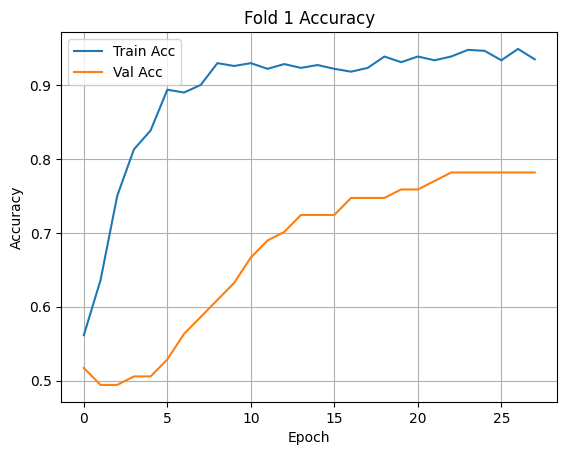

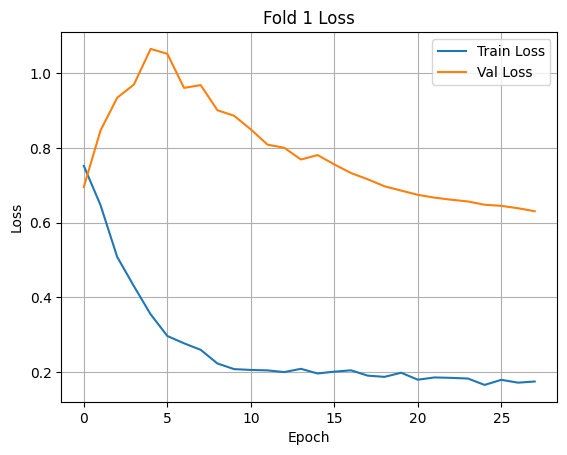

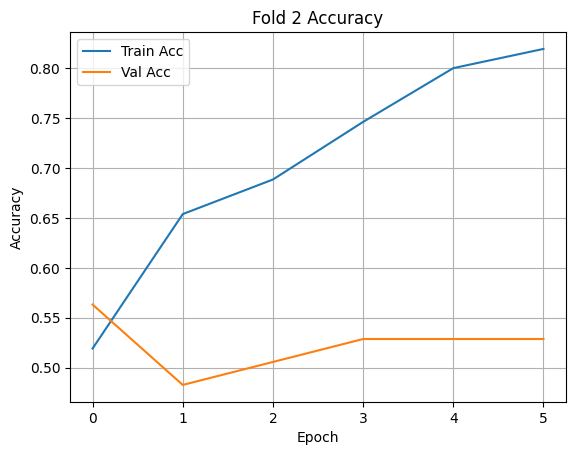

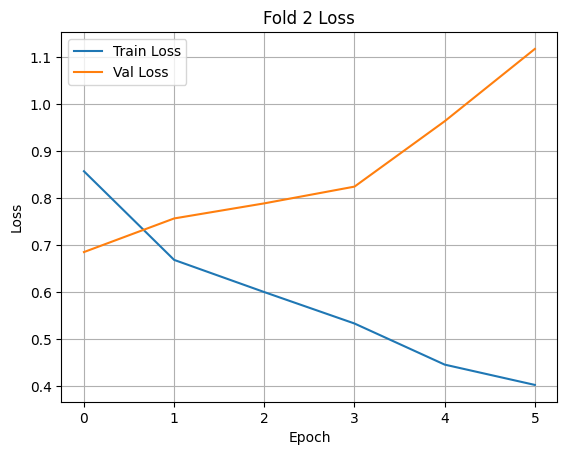

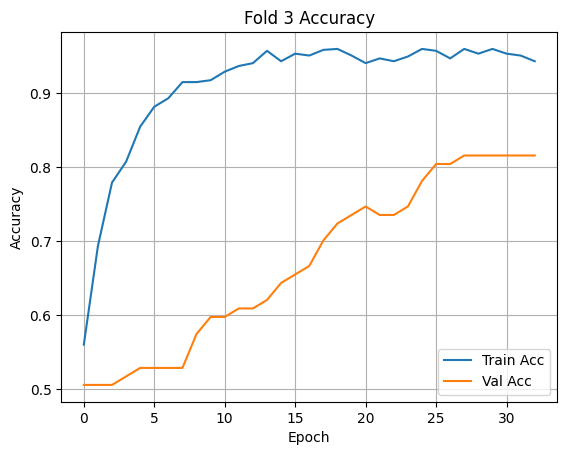

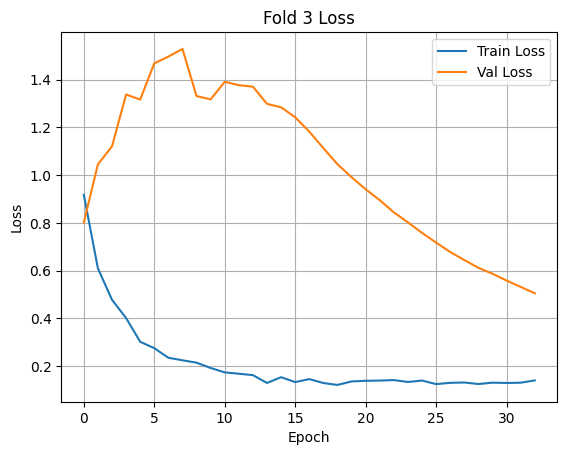

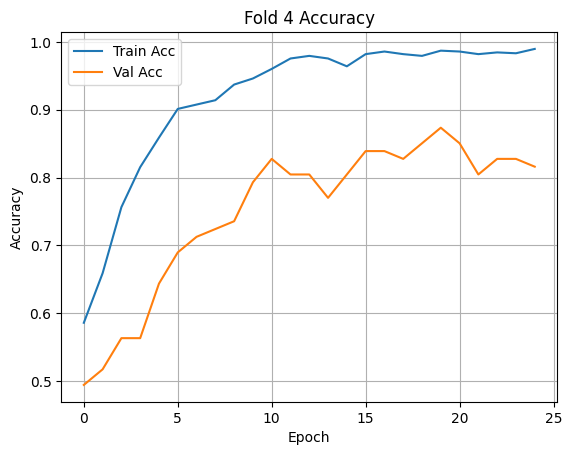

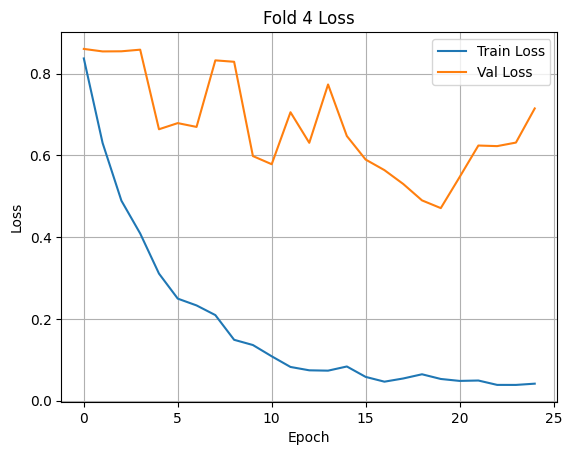

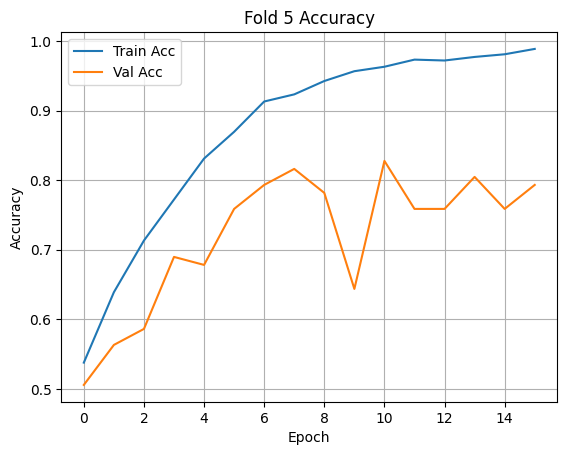

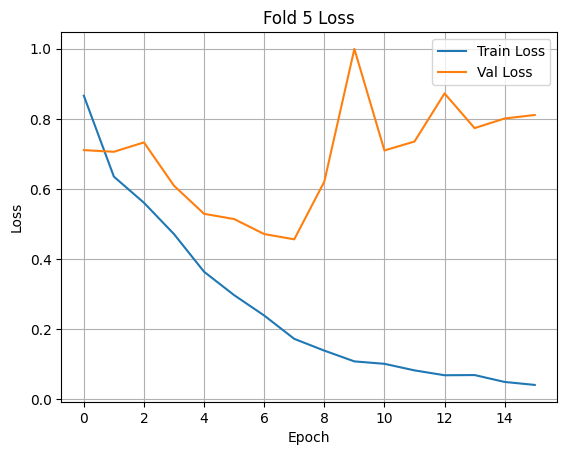

In [10]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_hmm_faceplus_final.h5")


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.694760
precision    0.624844
recall       0.647401
f1           0.614269
auc          0.847906
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.502304,0.000000,0.000000,0.000000,0.918960
1,2,0.520737,0.510101,0.935185,0.660131,0.554706
2,3,0.788018,0.956522,0.605505,0.741573,0.925586
3,4,0.847926,0.887755,0.798165,0.840580,0.926096
4,5,0.814815,0.769841,0.898148,0.829060,0.914180


In [13]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.694760
precision    0.624844
recall       0.647401
f1           0.614269
auc          0.847906
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.6948
📈 Range Accuracy: 0.3456
📉 Accuracy CV% (std/mean): 24.29%


,fold,accuracy,precision,recall,f1,auc
0,1,0.502304,0.000000,0.000000,0.000000,0.918960
1,2,0.520737,0.510101,0.935185,0.660131,0.554706
2,3,0.788018,0.956522,0.605505,0.741573,0.925586
3,4,0.847926,0.887755,0.798165,0.840580,0.926096
4,5,0.814815,0.769841,0.898148,0.829060,0.914180
